# Sequential Estimators of Binary Sequences

This notebook presents and implements a few methods of sequentially predicting binary sequences.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Formulation

Suppose we are continuously receiving a sequence of bits, $X^N = (X_1,X_2, \dots,X_N) \in \{0,1\}^N$, where each bit is distributed iid Bernoulli, i.e. $X_n \sim B(\theta)$ for $n=1,\dots,N$ with $\theta \in [0,1]$. Our goal is to, at each time $n$, estimate a probability assignment for the next bit:

$$
\hat{P}(x_{n+1} \mid x^n)
$$

Because there are only two possible values that $x_{n+1}$, we can equivalently estimate $\hat{P}_0 = Pr\{x_{n+1} = 0 \}$ and $\hat{P}_1 = Pr\{x_{n+1} = 1 \}$. Noting that we must have the relationship $\hat{P}_0 = 1 - \hat{P}_1$, we can define $\hat{\theta} = \hat{P}_1$ and our estimate for each $n$ becomes:

$$
\hat{P}(x_{n+1} \mid x^n) = \hat{\theta}^{x_{n+1}}(1-\hat{\theta})^{1-x_{n+1}}
$$

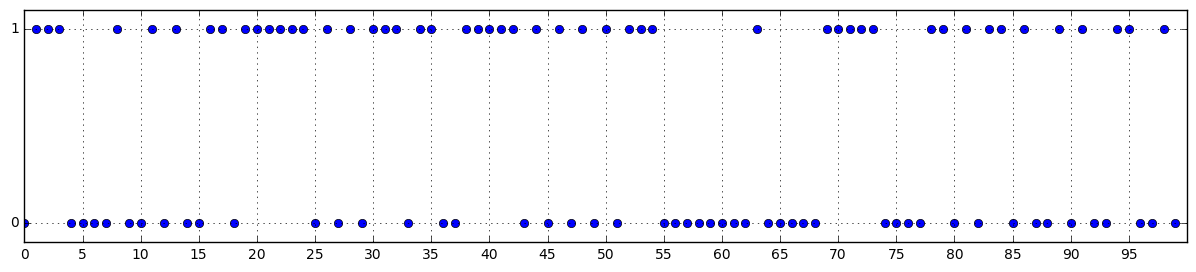

In [9]:
def gen_sequence(N=100,theta=0.5,plot = True):
    seq = np.random.binomial(1,theta,N)
    if not plot:
        return seq
    else:
        fig,ax = plt.subplots(figsize = (15,3))
        ax.plot(seq,'o')
        ax.xaxis.set(ticks=np.arange(0,N,N//20))
        ax.yaxis.set(ticks=(0,1), ticklabels=('0', '1'))
        ax.set_ylim([-0.1,1.1])
        ax.grid('on')
        return seq, ax
        
gen_sequence();

## Estimators

There are a number of ways to predict the probability of heads on the next outcome given all the past outcomes. Here we consider and implement a number of them!

### Maximum Likelihood Estimator
If we assume that our sequence is iid, then estimating the distribution of the next observation is equivalent to estimating the distribution based on the past observations. Using a maximum likelihood approach, this means that at each time $n$, we want to find the parameter $\hat{\theta} \in [0,1]$ that maximizes the likelihood of seeing the sequence so far, $x^n$. Formally, letting $M_n$ be the number of ones in the sequence thus far (and thus $n - M_n$ the number of zeroes):

\begin{align*}
\hat{\theta}_n^{ML} 
&= \underset{\theta\in[0,1]}{\operatorname{argmax}} P(x^{n-1} ; \theta) \\
&= \underset{\theta\in[0,1]}{\operatorname{argmax}} \theta^M_{n-1} (1-\theta)^(n-M_{n-1}) \\
&= \underset{\theta\in[0,1]}{\operatorname{argmax}} M_{n-1}\log\theta  + (n-1-M_{n-1}) \log(1-\theta) 
\end{align*}

Taking the derivative and setting to zero:

\begin{align*}
&\frac{d}{d\theta} P(x_{n-1} ; \theta) = 0 \\
& (1-\hat{\theta}_n^{ML})M_{n-1} = \hat{\theta}_n^{ML}(n-1-M_{n-1}) \\
& \hat{\theta}_n^{ML} = \frac{M_{n-1}}{n-1}
\end{align*}

In [458]:
class MLEstimator:
    
    def __init__(self,seq):
        self.label = "ML"
        self.seq = seq
        self.p1 = 1/2
        self.M = 0
        self.n = 1
        
    def predict(self):
        est_p1 = [self.p1]
        for xn in self.seq:
            self.n += 1
            self.M += xn
            self.p1 = self.M / (self.n-1)
            est_p1.append(self.p1)
        return est_p1

### KT-Estimator

In [459]:
class KTEstimator:
    
    def __init__(self,seq):
        self.label = "KT"
        self.seq = seq
        self.p1 = 1/2
        self.count1 = 0
        self.count0 = 0
        
    def predict(self):
        est_p1 = [self.p1]
        for xn in self.seq:
            self.count1 += xn
            self.count0 += (1-xn)
            self.p1 = ((0.5 + self.count1) / (self.count1 + self.count0 + 1))
            est_p1.append(self.p1)
        return est_p1

### Fixed Share Forecaster

In [460]:
class FSFEstimator:
    
    def __init__(self,seq,K=50,alpha=0,eta=0.1):
        self.label = "FSF"
        self.seq = seq
        self.K = K
        self.alpha = alpha
        self.eta = eta
        self.w = np.ones(self.K)*(1/self.K)
        self.p = self.w
        self.v = np.zeros_like(self.p)
        self.I = np.linspace(0,1,self.K)
        
    def predict(self):
        est_p1 = []
        for xn in self.seq:
            for i in range(self.K):
                self.v[i] = self.w[i]*np.exp(self.eta*np.log(xn*(self.I[i])+(1-xn)*(1-self.I[i])))
            for i in range(self.K):
                self.w[i] = self.alpha*(np.sum(self.v)/self.K) + (1-self.alpha)*self.v[i]
            for i in range(self.K):
                self.p[i] = self.w[i]/np.sum(self.w)
            #est_p1.append(self.I[np.argmax(self.w)])
            est_p1.append(np.dot(self.I,self.p))
        return est_p1

## Simulations

In [464]:
estimators = [MLEstimator,KTEstimator]

### Stationary Distribution

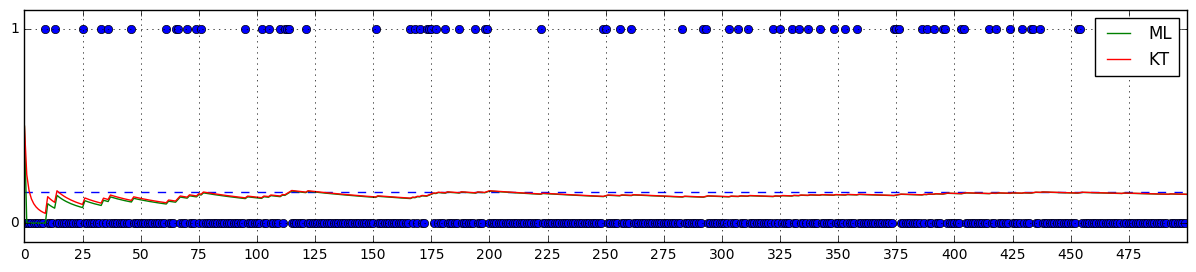

In [462]:
true_p = np.random.uniform()
N = 500
seq, ax = gen_sequence(N=N,theta=true_p)
ax.plot([0,N],[true_p,true_p],'b--')
for estimator_type in estimators:
    estimator = estimator_type(seq)
    est_p = estimator.predict()
    ax.plot(est_p,label=estimator.label)
plt.legend();

### Time-Varying Distribution

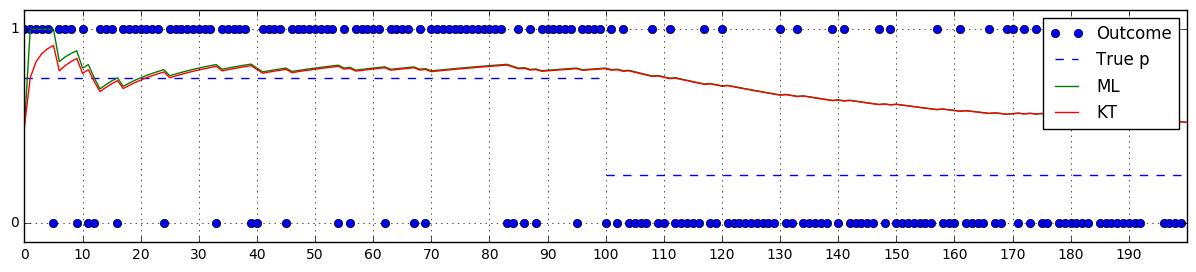

In [463]:
N = 200
true_p1 = 0.75
seq1 = gen_sequence(N=N//2,theta=true_p1,plot=False)
true_p2 = 0.25
seq2 = gen_sequence(N=N//2,theta=true_p2,plot=False)
seq = np.hstack((seq1,seq2))

fig,ax = plt.subplots(figsize = (15,3))
ax.plot(seq,'o',label='Outcome')
ax.plot([0,N//2],[true_p1,true_p1],'b--',label='True p')
ax.plot([N//2,N],[true_p2,true_p2],'b--')

for estimator_type in estimators:
    estimator = estimator_type(seq)
    est_p = estimator.predict()
    ax.plot(est_p,label=estimator.label)
    
ax.xaxis.set(ticks=np.arange(0,N,N//20))
ax.yaxis.set(ticks=(0,1), ticklabels=('0', '1'))
ax.set_ylim([-0.1,1.1])
ax.legend()
ax.grid('on')